# 📊 Estimación de $p_c$, Clúster Máximo y Clúster Medio
Este notebook estima:
- El valor crítico de percolación \( p_c \)
- El tamaño del clúster máximo
- El tamaño del clúster medio
mediante simulaciones múltiples del modelo de percolación.

p_c (cruce 0.5) ≈ 0.0000
χ_t(p_c) (cluster medio raíz) ≈ 21.00
Cluster máximo medio en p_c ≈ 21.00
θ_t(p_c) (chequeo) ≈ 1.000


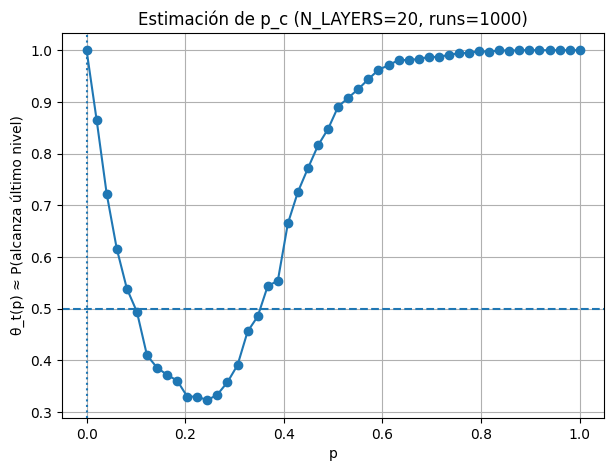

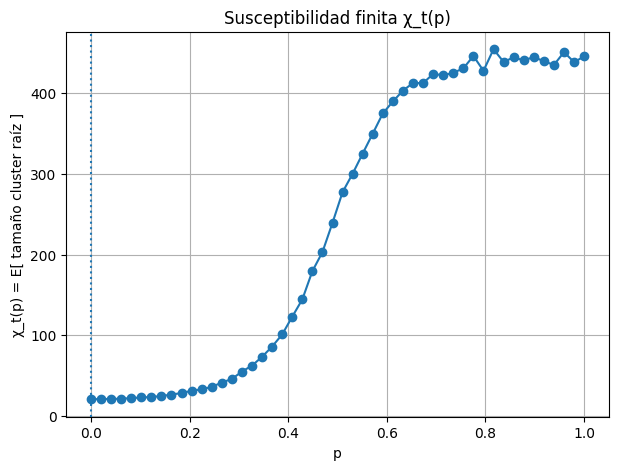

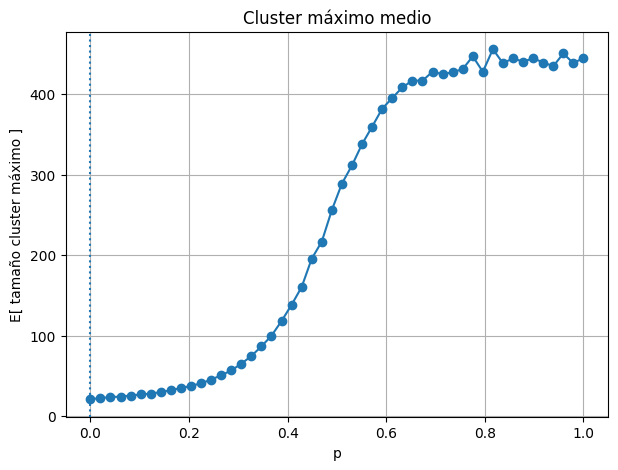

In [1]:
# =========================================================
#   Percolación en Triangulaciones Causales (GW + Spine)
#   Implementación fiel al examen con pasos g, r, s + batch
#   Métricas: p_crítico, χ_t(p), cluster máximo medio
# =========================================================
# Requisitos: numpy, matplotlib
# ---------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional

# ---------------------------------------------------------
# 0) UTILIDADES TEÓRICAS
# ---------------------------------------------------------
# En el examen, la triangulación causal crítica se genera a partir
# de un árbol de Galton–Watson condicionado (spine decomposition):
#   - La "espina" (root actual en cada nivel) tiene descendencia ~ ρ_k
#   - Los demás vértices (no-spine) tienen descendencia ~ p_k
#   - El nuevo spine se elige uniformemente entre los hijos del spine
#
# Percolación Bernoulli:
#   - Cada arista (del strip y del anillo) se abre con probabilidad p
#   - r-step: aplicar Bernoulli(p) en TIEMPO y AUXILIARES del strip i->i+1
#   - s-step: aplicar Bernoulli(p) en ESPACIO (anillo) del nivel i+1
#   - La conectividad efectiva se refleja en las etiquetas de "cluster"
# ---------------------------------------------------------

def sample_pk(rng: np.random.Generator) -> int:
    """
    p_k = 1/2^{k+1}, k >= 0  (geométrica con p=1/2, soporte incluye 0)
    Implementación: Geometric(0.5) - 1
    """
    return rng.geometric(p=0.5) - 1

def sample_rho(rng: np.random.Generator) -> int:
    """
    ρ_k = k / 2^{k+1}, k >= 1  (sesgada por tamaño; 'size-biased')
    Muestreo por inversa de la CDF: F(n) = 1 - (n+2)/2^{n+1}.
    >>> La espina NUNCA tiene 0 hijos (k>=1), crucial para no-extinción.
    """
    u = rng.random()
    n = 1
    while True:
        if u <= 1 - (n + 2) / (2 ** (n + 1)):
            return n
        n += 1

class DSU:
    """
    Disjoint Set Union (Union-Find) para fusionar componentes (clusters).
    - find: path compression
    - union: union by rank
    """
    def __init__(self, n: int):
        self.parent = list(range(n))
        self.rank = [0]*n
        self.size = [1]*n
    def find(self, x: int) -> int:
        while self.parent[x] != x:
            self.parent[x] = self.parent[self.parent[x]]
            x = self.parent[x]
        return x
    def union(self, a: int, b: int):
        ra, rb = self.find(a), self.find(b)
        if ra == rb: return
        if self.rank[ra] < self.rank[rb]:
            self.parent[ra] = rb; self.size[rb] += self.size[ra]
        elif self.rank[ra] > self.rank[rb]:
            self.parent[rb] = ra; self.size[ra] += self.size[rb]
        else:
            self.parent[rb] = ra; self.rank[ra] += 1; self.size[ra] += self.size[rb]

# ---------------------------------------------------------
# 1) g–step: GENERACIÓN por espina (como en el examen)
# ---------------------------------------------------------
# Devuelve:
#   - layers[i]: IDs globales en el nivel i
#   - spine_ids[i]: ID del spine en el nivel i (o -1)
#   - splits[i]: [k_1,...,k_m] hijos por padre (strip i->i+1)
# Notas:
#   * Spine ~ ρ; no-spine ~ p_k
#   * Nuevo spine = hijo elegido uniformemente entre los del spine
# ---------------------------------------------------------

def generate_layers_with_splits(n_layers: int, rng: np.random.Generator):
    layers = [[0]]             # nivel 0: raíz id 0
    spine_ids = [0]            # spine inicial = raíz
    splits: List[List[int]] = []
    next_id = 1

    # Nivel 0: raíz ~ ρ (nunca 0)
    k0 = sample_rho(rng)
    splits.append([k0])
    level1 = list(range(next_id, next_id + k0)); next_id += k0
    layers.append(level1)
    new_spine = level1[rng.integers(0, k0)] if k0 > 0 else -1
    spine_ids.append(new_spine)

    # Niveles siguientes
    for i in range(1, n_layers):
        parents = layers[i]
        split_i, next_level = [], []
        spine_id = spine_ids[i]
        for pid in parents:
            k = sample_rho(rng) if (pid == spine_id and spine_id != -1) else sample_pk(rng)
            split_i.append(k)
            children = list(range(next_id, next_id + k)); next_id += k
            next_level.extend(children)
        splits.append(split_i)
        layers.append(next_level)

        # Elegir nuevo spine si el spine actual tuvo hijos
        if spine_id != -1:
            idx_sp = parents.index(spine_id); k_sp = split_i[idx_sp]
            if k_sp > 0:
                start = sum(split_i[:idx_sp])
                new_spine = next_level[start + rng.integers(0, k_sp)]
            else:
                new_spine = -1
        else:
            new_spine = -1
        spine_ids.append(new_spine)

    return layers, spine_ids, splits

# ---------------------------------------------------------
# 2) TOPOLOGÍA DEL STRIP (para r-step) — tiempo y auxiliares
# ---------------------------------------------------------
# strip_edges(parents, children, k_list) genera:
#   - TIEMPO: (padre -> cada hijo) en el strip i->i+1
#   - AUXILIARES (en i+1): último hijo de j con primer hijo del
#     siguiente padre con hijos (cierre circular), como en el examen.
# ---------------------------------------------------------

def partition_children(children: List[int], k_list: List[int]) -> List[List[int]]:
    groups, pos = [], 0
    for k in k_list:
        groups.append(children[pos:pos+k]); pos += k
    return groups

def strip_edges(parents: List[int], children: List[int], k_list: List[int]):
    time_e, aux_e = [], []
    if not parents or not children:
        return time_e, aux_e
    groups = partition_children(children, k_list)
    # Tiempo
    for j, p in enumerate(parents):
        for c in groups[j]:
            time_e.append((p, c))
    # Auxiliares (circular entre grupos contiguos con hijos)
    m = len(parents)
    if m >= 2:
        for j in range(m):
            if not groups[j]: continue
            last_c = groups[j][-1]
            s = (j+1) % m
            while s != j and not groups[s]:
                s = (s+1) % m
            if s != j and groups[s]:
                aux_e.append((last_c, groups[s][0]))
    return time_e, aux_e

# ---------------------------------------------------------
# 3) r–step: Bernoulli(p) en TIEMPO + AUXILIARES del strip
# ---------------------------------------------------------
# Teoría (examen):
#   - TIEMPO abierto => el hijo HEREDA la etiqueta del padre
#   - AUX abierta     => fusiona hijos de padres contiguos (en i+1)
# Implementación:
#   - v_prev: etiquetas en nivel i
#   - v_next: etiquetas preliminares en nivel i+1 tras r-step
#   - DSU local sobre i+1 para fusionar por auxiliares
# ---------------------------------------------------------

def r_step_update(
    v_prev: List[int],
    parents: List[int],
    children: List[int],
    k_list: List[int],
    p: float,
    rng: np.random.Generator
) -> List[int]:
    L = len(children)
    if L == 0: return []
    idx_child = {cid: j for j, cid in enumerate(children)}
    v_next = [j+1 for j in range(L)]  # etiquetas provisionales únicas
    dsu = DSU(L)

    t_e, a_e = strip_edges(parents, children, k_list)
    pos_parent = {pid: j for j, pid in enumerate(parents)}

    # TIEMPO: herencia de color con prob. p
    for (p_id, c_id) in t_e:
        if rng.random() < p:
            v_next[idx_child[c_id]] = v_prev[pos_parent[p_id]]

    # AUXILIARES: fusionar en i+1 con prob. p
    for (c1, c2) in a_e:
        if rng.random() < p:
            dsu.union(idx_child[c1], idx_child[c2])

    # Compactar etiquetas por clases (min etiqueta en la clase)
    root_min = {}
    for j in range(L):
        r = dsu.find(j)
        root_min.setdefault(r, v_next[j])
        root_min[r] = min(root_min[r], v_next[j])
    out = v_next[:]
    for j in range(L):
        out[j] = root_min[dsu.find(j)]
    return out

# ---------------------------------------------------------
# 4) s–step: Bernoulli(p) en ESPACIO (anillo) del nivel i+1
# ---------------------------------------------------------
# Teoría (examen):
#   - Se recorren vecinos en el anillo; cada borde se abre con prob. p
#   - Si abre, se fusionan sus etiquetas (segunda actualización)
# ---------------------------------------------------------

def s_step_update(
    v_next: List[int],          # etiquetas tras r-step
    children_level: List[int],  # ids del nivel i+1 (solo para orden)
    p: float,
    rng: np.random.Generator
) -> List[int]:
    L = len(v_next)
    if L <= 1: return v_next[:]
    dsu = DSU(L)
    for i in range(L):
        j = (i+1) % L
        if rng.random() < p:
            dsu.union(i, j)
    # Compactar etiquetas por clases
    root_min = {}
    for i in range(L):
        r = dsu.find(i)
        root_min.setdefault(r, v_next[i])
        root_min[r] = min(root_min[r], v_next[i])
    out = v_next[:]
    for i in range(L):
        out[i] = root_min[dsu.find(i)]
    return out

# ---------------------------------------------------------
# 5) UNA SIMULACIÓN COMPLETA (g + r + s) y mediciones
# ---------------------------------------------------------

@dataclass
class SimResult:
    layers: List[List[int]]
    cluster_labels: List[List[int]]  # etiquetas finales por nivel (orden de layers[i])

def run_one(n_layers: int, p: float, rng: np.random.Generator) -> SimResult:
    # g-step
    layers, spine_ids, splits = generate_layers_with_splits(n_layers, rng)
    # etiquetas por nivel (nivel 0 = raíz con etiqueta 1)
    cluster_labels = [[1]]
    # strip por strip
    for i in range(len(layers)-1):
        parents, children = layers[i], layers[i+1]
        k_list = splits[i] if i < len(splits) else [0]*len(parents)
        v_prev = cluster_labels[i]
        v_next = r_step_update(v_prev, parents, children, k_list, p, rng)       # r-step
        v_next = s_step_update(v_next, children, p, rng)                        # s-step
        cluster_labels.append(v_next)
    return SimResult(layers, cluster_labels)

# Medidas:
#   - root_cluster_size: tamaño del cluster que contiene a la raíz
#   - max_cluster_size:  tamaño del cluster más grande del grafo
#   - spanning: ¿el cluster de la raíz alcanza el último nivel?
def measure_run(sim: SimResult) -> Tuple[int, int, bool]:
    # Index global de nodos (nivel,id) -> entero
    all_nodes = []
    for d, lvl in enumerate(sim.layers):
        for gid in lvl:
            all_nodes.append((d, gid))
    index = {node: i for i, node in enumerate(all_nodes)}
    dsu = DSU(len(all_nodes))

    # Unimos por etiqueta dentro de cada nivel
    for d, labels in enumerate(sim.cluster_labels):
        gids = sim.layers[d]
        buckets: Dict[int, List[int]] = {}
        for j, gid in enumerate(gids):
            buckets.setdefault(labels[j], []).append(index[(d, gid)])
        for idxs in buckets.values():
            for a, b in zip(idxs, idxs[1:]):
                dsu.union(a, b)

    # Unimos entre niveles consecutivos si comparten etiqueta (representante por etiqueta)
    for d in range(len(sim.layers)-1):
        lab_to_idx_d: Dict[int, List[int]] = {}
        lab_to_idx_u: Dict[int, List[int]] = {}
        for j, gid in enumerate(sim.layers[d]):
            lab = sim.cluster_labels[d][j]
            lab_to_idx_d.setdefault(lab, []).append(index[(d, gid)])
        for j, gid in enumerate(sim.layers[d+1]):
            lab = sim.cluster_labels[d+1][j]
            lab_to_idx_u.setdefault(lab, []).append(index[(d+1, gid)])
        common_labels = set(lab_to_idx_d.keys()) & set(lab_to_idx_u.keys())
        for lab in common_labels:
            dsu.union(lab_to_idx_d[lab][0], lab_to_idx_u[lab][0])

    # Tamaños de componentes
    comp_size: Dict[int, int] = {}
    for i in range(len(all_nodes)):
        r = dsu.find(i)
        comp_size[r] = comp_size.get(r, 0) + 1

    # Cluster de la raíz y cluster máximo
    root_idx = index[(0, sim.layers[0][0])]
    root_comp = dsu.find(root_idx)
    root_size = comp_size[root_comp]
    max_size = max(comp_size.values()) if comp_size else 0

    # ¿Alcanza el último nivel?
    last_d = len(sim.layers) - 1
    spanning = any(dsu.find(index[(last_d, gid)]) == root_comp for gid in sim.layers[last_d])
    return root_size, max_size, spanning

# ---------------------------------------------------------
# 6) EXPERIMENTO BATCH: 1000 simulaciones por p y p_crítico
# ---------------------------------------------------------

def run_batch(P_GRID, NUM_RUNS=1000, N_LAYERS=12, SEED=2025):
    """
    Corre NUM_RUNS simulaciones por cada p en P_GRID.
    Devuelve un array con columnas:
      [ p, chi_hat(p), max_mean(p), theta_hat(p) ]
    donde:
      - chi_hat(p)   = E[tamaño del cluster de la raíz]
      - max_mean(p)  = E[tamaño cluster máximo]
      - theta_hat(p) = P( la raíz alcanza el último nivel )
    """
    rng_master = np.random.default_rng(SEED)
    stats = []
    for p in P_GRID:
        root_sizes, max_sizes, spans = [], [], 0
        for _ in range(NUM_RUNS):
            rng = np.random.default_rng(rng_master.integers(0, 2**31-1))
            sim = run_one(N_LAYERS, p, rng)
            rs, ms, sp = measure_run(sim)
            root_sizes.append(rs); max_sizes.append(ms); spans += int(sp)
        chi = float(np.mean(root_sizes))
        max_mean = float(np.mean(max_sizes))
        theta = spans/NUM_RUNS
        stats.append((p, chi, max_mean, theta))
    return np.array(stats, float)

def estimate_pc_from_crossing(stats: np.ndarray) -> float:
    """
    Estima p_crítico como el primer cruce de theta_hat(p) con 0.5,
    usando interpolación lineal entre los dos puntos adyacentes.
    """
    p = stats[:,0]; th = stats[:,3]
    # índice del primer punto con theta >= 0.5
    idxs = np.where(th >= 0.5)[0]
    if len(idxs) == 0:
        return p[-1]
    idx = idxs[0]
    if idx == 0:
        return p[0]
    p0, t0 = p[idx-1], th[idx-1]
    p1, t1 = p[idx], th[idx]
    if t1 == t0:
        return p1
    # Interpolación lineal
    return p0 + (0.5 - t0) * (p1 - p0) / (t1 - t0)

# ---------------------------------------------------------
# 7) MAIN: Ejecuta, estima p_c, grafica y (opcional) guarda CSV
# ---------------------------------------------------------

if __name__ == "__main__":
    # Parámetros del experimento (ajústalos a gusto)
    N_LAYERS = 20           # profundidad de la triangulación (truncación)
    NUM_RUNS = 1000         # simulaciones por punto
    P_GRID   = np.linspace(0.0, 1, 50)  # rango de p con paso 0.02
    SAVE_CSV = False        # True para guardar CSV

    # 1) Barrido de p y métricas
    stats = run_batch(P_GRID, NUM_RUNS, N_LAYERS, SEED=1234)
    # stats[:,0]=p; [:,1]=chi_hat; [:,2]=max_mean; [:,3]=theta_hat

    # 2) Estimar p_c por cruce 0.5 de theta_hat(p)
    pc_hat = estimate_pc_from_crossing(stats)

    # 3) Métricas en p_c (repetimos 1000 simulaciones sólo en p_c)
    stats_pc = run_batch(np.array([pc_hat]), NUM_RUNS, N_LAYERS, SEED=5678)
    chi_pc, max_pc, theta_pc = stats_pc[0,1], stats_pc[0,2], stats_pc[0,3]

    # ---- Impresión de resultados clave ----
    print(f"p_c (cruce 0.5) ≈ {pc_hat:.4f}")
    print(f"χ_t(p_c) (cluster medio raíz) ≈ {chi_pc:.2f}")
    print(f"Cluster máximo medio en p_c ≈ {max_pc:.2f}")
    print(f"θ_t(p_c) (chequeo) ≈ {theta_pc:.3f}")

    # 4) GRÁFICAS (una por figura)
    # θ_t(p): prob. de alcanzar el último nivel (proxy de percolación)
    plt.figure(figsize=(7,5))
    plt.plot(stats[:,0], stats[:,3], marker='o')
    plt.axhline(0.5, linestyle='--')
    plt.axvline(pc_hat, linestyle=':')
    plt.xlabel("p"); plt.ylabel("θ_t(p) ≈ P(alcanza último nivel)")
    plt.title(f"Estimación de p_c (N_LAYERS={N_LAYERS}, runs={NUM_RUNS})")
    plt.grid(True)
    plt.show()

    # χ_t(p): tamaño medio del cluster de la raíz
    plt.figure(figsize=(7,5))
    plt.plot(stats[:,0], stats[:,1], marker='o')
    plt.axvline(pc_hat, linestyle=':')
    plt.xlabel("p"); plt.ylabel("χ_t(p) = E[ tamaño cluster raíz ]")
    plt.title("Susceptibilidad finita χ_t(p)")
    plt.grid(True)
    plt.show()

    # Cluster máximo medio
    plt.figure(figsize=(7,5))
    plt.plot(stats[:,0], stats[:,2], marker='o')
    plt.axvline(pc_hat, linestyle=':')
    plt.xlabel("p"); plt.ylabel("E[ tamaño cluster máximo ]")
    plt.title("Cluster máximo medio")
    plt.grid(True)
    plt.show()

    # 5) (Opcional) Guardar CSV
    if SAVE_CSV:
        import csv
        with open("batch_percolation_results.csv", "w", newline="") as f:
            w = csv.writer(f)
            w.writerow(["p", "chi_hat_root", "max_cluster_mean", "theta_hat"])
            for row in stats:
                w.writerow([f"{row[0]:.6f}", f"{row[1]:.6f}", f"{row[2]:.6f}", f"{row[3]:.6f}"])
        print("CSV guardado en batch_percolation_results.csv")
